In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import json

In [3]:
# obs_bayes2_m23m28 = pd.read_csv("obs_bayes2_m23m28.csv")
obs_bayes2_m15a01 = pd.read_csv("obs_bayes2_m15a01.csv")
# obs_bayes2_j01f28 = pd.read_csv("obs_bayes2_j01f28.csv")

all_obs = [
#     obs_bayes2_m23m28,
    obs_bayes2_m15a01,
#     obs_bayes2_j01f28,
]
all_labels = [
#     'bayes2_m23m28',
    'bayes2_m15a01',
#     'bayes2_j01f28',
]

def add_cols(df):
    if 'date' in df.columns and 'time' in df.columns:
        df['datetime'] = (df['date'] + ' ' + df['time']).apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d %I:%M %p'))
        df.drop(['date','time'], axis=1, inplace=True)
    else:
        df['datetime'] =  pd.to_datetime(df['datetime'])
    
for ob in all_obs:
    add_cols(ob)

In [4]:
def extract_dict(row, col_name):
    return json.loads(row.replace("\'", "\""))
def get_scores(df):
    return df['scores'].apply(lambda x: extract_dict(x, 'scores'))
def get_pools_i(df):
    return df['pools_i'].apply(lambda x: extract_dict(x, 'pools_i'))

def b_star(omega, omega_i, s, p_i):
    if p_i <= omega_i/(s*omega):
        return 0
    root = np.sqrt((omega_i**2)*(s*p_i-1)**2 - (s*p_i-1)*(s*p_i*omega*omega_i - (omega_i**2)) )
    return max(-omega_i + 2*root/(2*(s*p_i)-1), -omega_i - 2*root/(2*s*p_i-2))

def number_only(n):
    return n if n[-1].isdigit() else n[:-1]

def sim(df, money, E_money, verbose=False, graphs=False):
    if verbose:
        print("=====")
    ps = []
    results = []
    returns = []
    bet_times = []
    scores = get_scores(df)
    pools_i = get_pools_i(df)
    
    for j in range(df.shape[0]):
        if money[-1] < 30:
            break
        s = 1 - df['takeout'][j]
        pool = df['pool_size'][j]
        if df['num_horses'][j] > 9 or df['num_horses'][j] < 7:
            money.append(money[-1])
            E_money.append(E_money[-1])
            continue
        
        positive_horse_pEr_list = []
        skip_race = False
        for k,v in scores[j].items():            
            p = float(v)
            if p < 0.1:
                continue
            
            ps.append(p)
            pool_category = number_only(k)
            if pool_category not in pools_i[j].keys():
                skip_race = True
                break
    
            h0 = pools_i[j][pool_category]
            b = b_star(pool, h0, s, p)
            b = min(b, money[-1]) / 2
            odds = s*(pool+b)/(h0+b) - 1
            Er = (odds)*b*p - b*(1-p)
            if odds > (1/p) - 1:
                positive_horse_pEr_list.append([Er, b, odds, p, k, df['num_horses'][j], money[-1], j])
            else:
                if verbose:
                    pass
#                     print(f'below threshold. odds: {odds}, p: {p}')
        if skip_race:
            money.append(money[-1])
            E_money.append(E_money[-1])
            continue
        
        sorted_list = sorted(positive_horse_pEr_list, key=lambda x: -x[0])
        if sorted_list:
            Er, b, odds, p, choice, num_horses, cur_money, ji = sorted_list[0]
            
            winner = number_only(str(df['winner'][j]))
            choice = number_only(choice)
            
            E_money.append(E_money[-1] + Er)
            bet_times.append(df["datetime"][j])
            
            stats = f'b: {b}, odds: {odds}, p_hat: {p}, Er: {Er}, s: {s}, choice: {choice}, num_horses = {num_horses}, cur_money: {cur_money}.'
            if choice == winner:
                results.append(1)
                returns.append(b*odds)
                if verbose:
                    print(f'race {j}. datetime: {df["datetime"][j]}')
                    print(f'  Won ({b*odds}). {stats}')
                money.append(money[-1] + b*odds)
            else:
                results.append(0)
                returns.append(-b)
                if verbose:
                    pass
                    print(f'race {j}. datetime: {df["datetime"][j]}')
                    print(f'  Lost ({b}). {stats}')
                money.append(money[-1] - b)
        else:
            money.append(money[-1])
            E_money.append(E_money[-1])
    print(f'winrate: {np.average(results)}, wins: {np.sum(results)}, num bets: {len(results)}')  
    if graphs:
        plt.hist([bt.hour for bt in bet_times])
        plt.title('bet times')
        plt.show()
        plt.hist(returns)
        plt.title('returns')
        plt.show()
        plt.hist(ps)
        plt.title('p\'s')
        plt.show()
        
def sim_plots(dfs, labels):
    plt.figure(figsize=(5, 3), dpi=80)
    for df, label in zip(dfs, labels):
        df = df.sort_values('datetime')
        df = df.reset_index(drop=True)

        money = [100000]
        E_money = [100000]
        sim(df, money, E_money, verbose=True, graphs=False)
        plt.plot(df['datetime'][:len(money)-1], money[1:], label=label)
        plt.plot(df['datetime'][:len(E_money)-1], E_money[1:], label=f'E[{label}]')
    plt.grid()
    plt.xlabel('bets')
    plt.ylabel('cash')
    plt.legend()
    plt.show()

=====
below threshold. odds: 0.4955703598039367, p: 0.2123687281213535
race 0. datetime: 2022-03-15 16:01:00
  Lost (15.823536364280727). b: 15.823536364280727, odds: 7.338625560508307, p_hat: 0.1400233372228704, Er: 2.652059171517248, s: 0.8095634095634097, choice: 5, num_horses = 8, cur_money: 100000.
below threshold. odds: 0.9303868972161657, p: 0.1966911764705882
below threshold. odds: 6.596897824122956, p: 0.119485294117647
below threshold. odds: 3.388127473006506, p: 0.1323529411764706
below threshold. odds: 0.11074539663113003, p: 0.2123687281213535
race 3. datetime: 2022-03-15 16:50:00
  Lost (58.47989417140957). b: 58.47989417140957, odds: 12.381433307733616, p_hat: 0.101516919486581, Er: 20.961643660246388, s: 0.8080489288578848, choice: 5, num_horses = 8, cur_money: 99984.17646363573.
below threshold. odds: 2.524781559505387, p: 0.1400233372228704
below threshold. odds: 0.9418603092590778, p: 0.2123687281213535
below threshold. odds: 3.0343585832702704, p: 0.101516919486581


below threshold. odds: 2.114289299009064, p: 0.1323529411764706
below threshold. odds: 1.0630825781035935, p: 0.1966911764705882
below threshold. odds: 1.606152558932882, p: 0.2123687281213535
below threshold. odds: 2.3518850570367382, p: 0.1400233372228704
below threshold. odds: 3.3452777101273927, p: 0.101516919486581
below threshold. odds: 0.34561037931469296, p: 0.1966911764705882
below threshold. odds: 5.54736321374929, p: 0.1323529411764706
race 606. datetime: 2022-03-17 16:16:00
  Lost (389.2982097847839). b: 389.2982097847839, odds: 9.625654788885956, p_hat: 0.119485294117647, Er: 104.95849088026586, s: 0.8186794046236673, choice: 1, num_horses = 9, cur_money: 97424.6728782313.
below threshold. odds: 0.8141959630871518, p: 0.2377521613832853
below threshold. odds: 2.8943950500615485, p: 0.1210374639769452
below threshold. odds: 0.31521196965942977, p: 0.2377521613832853
below threshold. odds: 3.368987401357934, p: 0.1210374639769452
below threshold. odds: 0.9758261340678926, p:

below threshold. odds: 0.8500288694255416, p: 0.2123687281213535
below threshold. odds: 3.861270827962209, p: 0.1400233372228704
below threshold. odds: 4.936574974239565, p: 0.101516919486581
below threshold. odds: 3.4573504735508758, p: 0.101516919486581
below threshold. odds: 1.5341551559997235, p: 0.2123687281213535
below threshold. odds: 2.003045446163514, p: 0.1400233372228704
below threshold. odds: 3.230096355964916, p: 0.1400233372228704
below threshold. odds: 1.2299050989060083, p: 0.2123687281213535
below threshold. odds: 4.3874507189569165, p: 0.101516919486581
below threshold. odds: 2.3982757393210274, p: 0.119485294117647
below threshold. odds: 1.67241277358811, p: 0.1966911764705882
below threshold. odds: 1.9626510748145929, p: 0.1323529411764706
below threshold. odds: 1.9730404814067, p: 0.1210374639769452
below threshold. odds: 0.7437615365455046, p: 0.2377521613832853
below threshold. odds: 1.4396148692588318, p: 0.2123687281213535
below threshold. odds: 2.0920319824185

below threshold. odds: 2.4980259333191115, p: 0.1323529411764706
below threshold. odds: 3.4994041937110882, p: 0.1400233372228704
below threshold. odds: 3.5806575425817178, p: 0.101516919486581
below threshold. odds: 0.6819156994311653, p: 0.2123687281213535
below threshold. odds: 4.9901146138028905, p: 0.101516919486581
below threshold. odds: 3.4311948732231423, p: 0.1400233372228704
below threshold. odds: 2.837305173421397, p: 0.2123687281213535
below threshold. odds: 2.114736324278515, p: 0.1323529411764706
below threshold. odds: 1.6311084893928558, p: 0.1966911764705882
below threshold. odds: 4.202793194804308, p: 0.119485294117647
below threshold. odds: 0.9314312013322019, p: 0.1400233372228704
below threshold. odds: 0.9107372956036426, p: 0.2123687281213535
race 2991. datetime: 2022-03-24 19:17:00
  Lost (5.227576222793072). b: 5.227576222793072, odds: 13.485762766199509, p_hat: 0.101516919486581, Er: 2.4598360566558117, s: 0.8155586017820425, choice: 7, num_horses = 8, cur_money

below threshold. odds: 2.3006566765774923, p: 0.2123687281213535
below threshold. odds: 2.524968545546049, p: 0.1400233372228704
below threshold. odds: 3.5729321671948746, p: 0.101516919486581
below threshold. odds: 1.904901491249027, p: 0.1210374639769452
below threshold. odds: 0.8456499117614353, p: 0.2377521613832853
below threshold. odds: 1.9617393412190869, p: 0.2377521613832853
below threshold. odds: 3.9004823640226673, p: 0.1210374639769452
below threshold. odds: 0.6018535257665694, p: 0.2377521613832853
below threshold. odds: 3.287719997849309, p: 0.1210374639769452
below threshold. odds: 1.4388446430115223, p: 0.2377521613832853
below threshold. odds: 2.6426686353482856, p: 0.1210374639769452
below threshold. odds: 4.23420496414107, p: 0.1210374639769452
below threshold. odds: 0.645354288701252, p: 0.2377521613832853
below threshold. odds: 0.8054829041963771, p: 0.2377521613832853
below threshold. odds: 1.5568771700453623, p: 0.1210374639769452
below threshold. odds: 5.3311751

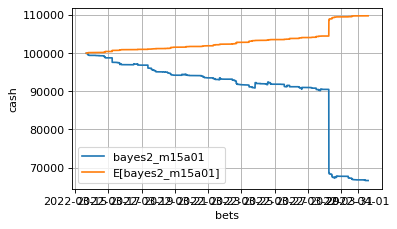

In [5]:
sim_plots(all_obs, all_labels)